# Черное золото

Мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину. Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов.

Условие задачи:
 - Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
 - При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
 - Бюджет на разработку скважин в регионе — 10 млрд рублей.
 - При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
 - После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

**Цель:**

Найти регион, где добыча принесет наибольшую прибыль.

**Задачи**:
1) Построить модель машинного обучения для определнеия региона с наибольшей прибыли от добычи.
2) Проанализировать возможноую прибыль и риски техникой *Bootstrap.*

**Этапы:**
1) Загрузка и подготовка данных.
2) Исследовательский анализ.
3) Обучение и проверка модели.
4) Подготовка к растчётам прибыли.
5) Расчёт прибыли и рисков.
6) Чек-лист готовности проета.

## Загрузка и подготовка данных

In [2]:
# для использования линейной алгебры
import numpy as np

#для графиков
import matplotlib.pyplot as plt
import seaborn as sns

#статистика 
import scipy.stats as st

# для работы с таблицами
import pandas as pd

# время загрузки
import time

# для разделение данных на выборки
from sklearn.model_selection import train_test_split


# загружаем классы для подготовки данных
from sklearn.preprocessing import (
        StandardScaler,
        MinMaxScaler,
        RobustScaler,
        PolynomialFeatures
)


# загружаем функцию для работы с метриками
from sklearn.metrics import (
        mean_squared_error
)

# загружаем нужные модели
from sklearn.linear_model import LinearRegression

from numpy.random import RandomState

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import  GridSearchCV

from sklearn.feature_selection import SelectKBest, f_regression


In [3]:
# константы 
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [4]:
#загружаем и сохрнаяем данные
try:
    geo_data_0 = pd.read_csv('geo_data_0.csv')
    geo_data_1 = pd.read_csv('geo_data_1.csv')
    geo_data_2 = pd.read_csv('geo_data_2.csv')
    
except:
    geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

Дальше проведем предобработку данных.

Для начала посмотрим как выглядят значения, корректны ли типы данных, названия столбцов. Всегда делаю данный шаг первым, так как выстраивается общая картина о данных, становится понятно из каких столбцов она состоит, какой тип данных преобладает, если ли пропуски, какие-то необычно большие или маленькие значения. Данные этап важен, так как банально не верный тип данных может привести к ошибкам при построении модели. 


Когда так скажем привели внешний вид таблицы в порядок, приступаем к обработке пропусков, явных и невных дубликаты. Для начала проверяю пропуски, так как после их заполения могут получиться дубликаты, хотя думаю особой разницы нет, в каком порядке проводить данные операции.

Затем подвожу итоги, что было изменено или добалено в данных, остались ли какие-либо проблемы.

In [5]:
#наглядно оценим данные таблиц
geo_data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [6]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
geo_data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [8]:
geo_data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [9]:
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [10]:
geo_data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [11]:
geo_data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [12]:
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [13]:
geo_data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


В целом данные выглядят корректно, но вызывают сомнения отрицательные значения в столбцах `f0`, `f1`, `f2` и большое кол-во чисел после запятой. Возможно, так и задумано. Также встречаются скважины, которые содержат нулевые запасы, это какие то выбросы, ошибки в данных, либо так и есть.

Дальше проверим кол-во пропусков и дубликтов.

In [14]:
# проверим кол-во пропусков
geo_data_0.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [15]:
geo_data_1.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [16]:
geo_data_2.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Пропусков не обнаружено.

Проверим явные и неявные дубликаты.

In [17]:
geo_data_0.duplicated().sum()

0

In [18]:
geo_data_1.duplicated().sum()

0

In [19]:
geo_data_2.duplicated().sum()

0

Явных дубликатов не обнаружено.

In [20]:
# проверим неявные дубликаты по нескольким столбцам
geo_data_0[['f0', 'f1', 'f2']].duplicated().sum()

0

In [21]:
geo_data_0[['id', 'product']].duplicated().sum()

0

In [22]:
# проверим неявные дубликаты по столбцу id
geo_data_0[['id']].duplicated().sum()

10

In [23]:
geo_data_0.loc[geo_data_0[['id']].duplicated() == True]

,id,f0,f1,f2,product
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
66136,74z30,1.084962,-0.312358,6.990771,127.643327
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
75715,Tdehs,0.112079,0.430296,3.218993,60.964018
90815,fiKDv,0.049883,0.841313,6.394613,137.346586
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008
97785,bsk9y,0.378429,0.005837,0.160827,160.637302


In [24]:
geo_data_0.query('id == "HZww2"')

,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695


Попадается небольшое кол-во неявных дубликатов по столбцу `id` в таблице `geo_data_0`.

Из своего нефтяного опыта могу сказать, что одна скважина может расцениваться как две, и соответсвенно давать разные объемы добычи. Всё дело в том, что в одной скважине может быть вскрыто несколько нефтяных пластов, которые имеют различные характеристки и в них содержатся разные запасы углеводородов. В таких случаях из одной скажины могут добывать только из одного пласта, так как второй пласт, например, содержит тяжелую нефть, в ней много вредных примесей, что может быть не рентабельно и проще остановиться на одном пласте, а бывает наоборот, решат добывать сразу из двух пластов, если это обосновано экономически и технически.

Думаю такие дубликаты можно оставить, если бы у них вообще все данные совпадали, то тогда можно было удалить.

In [25]:
geo_data_1[['f0', 'f1', 'f2']].duplicated().sum()

0

In [26]:
geo_data_1[['id', 'product']].duplicated().sum()

0

In [27]:
geo_data_1[['id']].duplicated().sum()

4

In [28]:
geo_data_1.loc[geo_data_1[['id']].duplicated() == True]

,id,f0,f1,f2,product
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


In [29]:
geo_data_1.query('id == "LHZR0"')

,id,f0,f1,f2,product
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625


По данным `geo_data_1`так же попадаются дубликаты по `id`, но остальные значения все различны.

In [30]:
geo_data_2[['f0', 'f1', 'f2']].duplicated().sum()

0

In [31]:
geo_data_2[['id', 'product']].duplicated().sum()

0

In [32]:
geo_data_2[['id']].duplicated().sum()

4

In [33]:
geo_data_2.loc[geo_data_2[['id']].duplicated() == True]

,id,f0,f1,f2,product
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


In [34]:
geo_data_2.query('id == "xCHr8"')

,id,f0,f1,f2,product
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


По данным `geo_data_2`аналогичная ситуация.

Вывод:
- Нулевые запасы на скважинах похожи на выбросы;
- Пропусков не обнаружено;
- Явные дубликаты отсутвуют;
- Попадается небольшое кол-во дубликатов по столбцу `id` во всех датасетах, но каких-то особых аномалий не обнаружено, оставили как есть.

## Исследовательский анализ

Исследуем данные, построим графики для распределения и диграмм размаха. Посмотрим как выглядят распределения, нет ли аномальных значений, выбросов. Проведем корреляционный анализ, проверим данные на мультиколлинеарность и утечку целевого признака.

In [35]:
# создаим функцию для построения гистрораммы и диаграммы размаха
def hist_box(data, column):
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.subplots_adjust(right=2)
    plt.xlabel(f'Значения столбца "{column}"')
    plt.ylabel('Частота')
    plt.title(f'Гистограмма для "{column}"')
    sns.histplot(data[column])
    plt.subplot(1, 2, 2)
    plt.xlabel(f'Значения столбца {column}')
    plt.title(f'Диаграмма размаха для {column}')
    sns.boxplot(x=data[column])

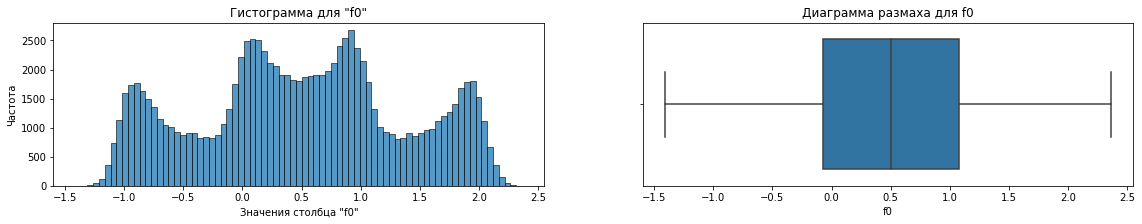

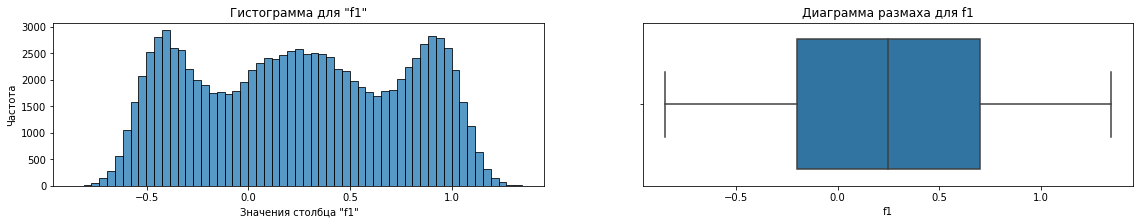

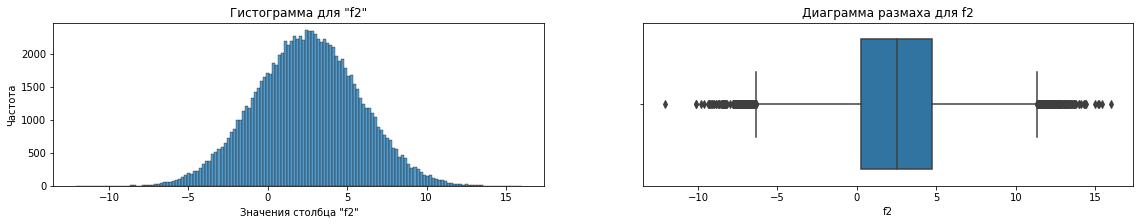

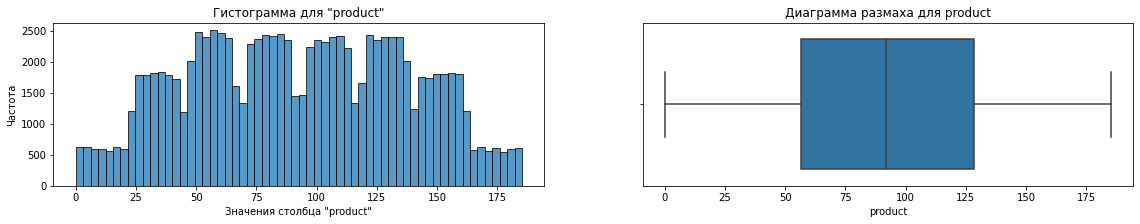

In [36]:
# вызовим функцию для построения гистрорамм и диаграмм размаха для количественных признаков
for name in geo_data_0.select_dtypes(include = 'number').columns:
    hist_box(geo_data_0, name)
    plt.show()

In [37]:
# посчтиаем сколько процентов потеряем данных от общего кол-во данных при удалении выбросов
(geo_data_0.query('(f2 > 11) or (f2 < -6)').shape[0] / geo_data_0.shape[0])*100


0.751

In [38]:
# посчитаем сколько потенциальной выручки в тыс.рублей можем потерять при удалении выбросов
# цена за 1 барраель 450 рублей
geo_data_0.query('(f2 > 11) or (f2 < -6)')['product'].sum() * 450

31685164.774292916

In [39]:
# посторим на слишком малые объемы запасов
geo_data_0.query('product < 1')

,id,f0,f1,f2,product
307,Y4DnV,0.502926,0.593209,-2.399415,0.078123
2229,NDc1S,0.763198,0.658588,-0.558619,0.038252
3784,mXdEt,0.086728,1.128861,-0.525895,0.050657
3789,dQc8v,0.710330,0.423648,0.424131,0.621153
4109,3RhgB,-0.714156,0.829910,3.795402,0.888251
...,...,...,...,...,...
97721,oZ3UJ,0.701532,0.808797,-2.221334,0.004022
97827,CVxJ4,-0.748880,0.584331,1.562582,0.722188
98058,U7LCe,-0.504360,0.754723,2.404490,0.250788
99489,IO55C,-0.531047,1.026292,0.764586,0.207958


Попадаются выбросы у признака `f2`, при их удалении можем потерять 0.76% данных, что допустимо. Если посмотреть с точки зрения сколько мы теряем прибыли при 450 рублей за баррель, получается приерно 31 685 164.65 тыс.рублей. Вообщем нет четких оснований удалять эти выбросы, потому что впринципе не понятно что означают данные признаки, возможно это вполне нормальные значения.

Также можно будет проверить как измениться качество модели с выбросами и без них.

Есть скважины с очень маленькими запасами, с точки зрения получения большей прибыли  они явно не интересны, но думаю для обучения модели и предсказания целевого признака может послужить примером какие скважины потеницально нерентабельны.

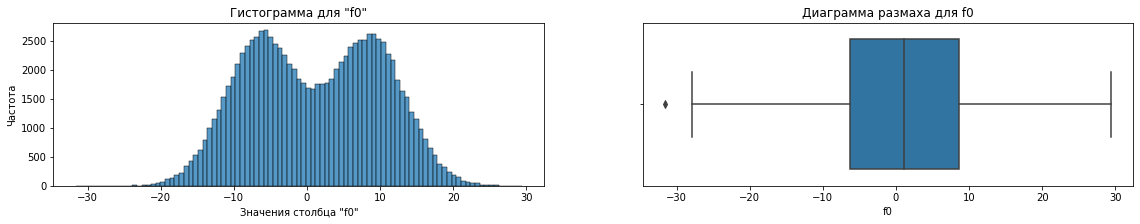

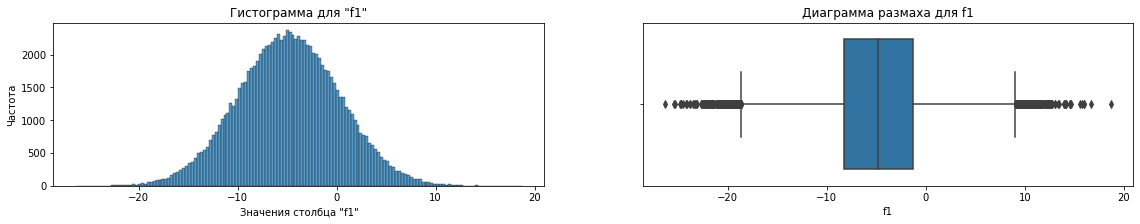

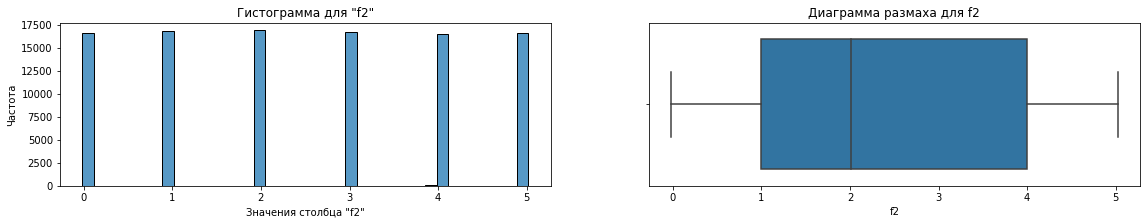

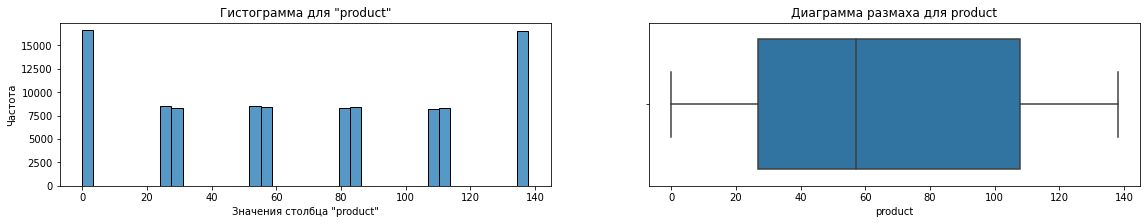

In [40]:
# вызовим функцию для построения гистрорамм и диаграмм размаха для количественных признаков
for name in geo_data_1.select_dtypes(include = 'number').columns:
    hist_box(geo_data_1, name)
    plt.show()

Для признака `f1` встречаются выбросы, но также нет оснований для их удаления.

Для признаков `f2` и `product` выделяются определенные категории, возможно их можно рассмотреть как категориальный признак, но опять же мало информации для обоснования.

Данные распределены  по дргуому, не так к в `geo_data_0`, скорей всего это из за различных свойств нефти, строения горной породы, либо нужно больше наблюдений, исследований для того, чтобы распределения получилались больше похожи на стандартные.

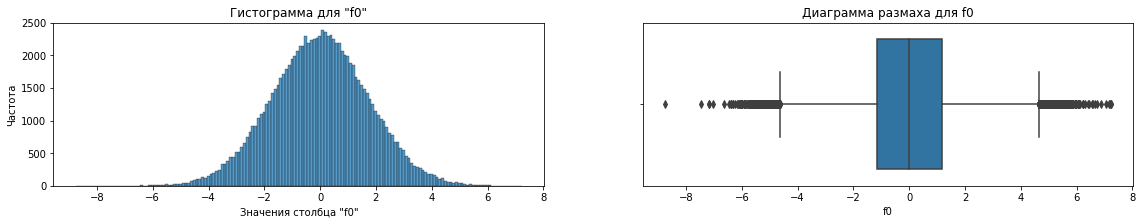

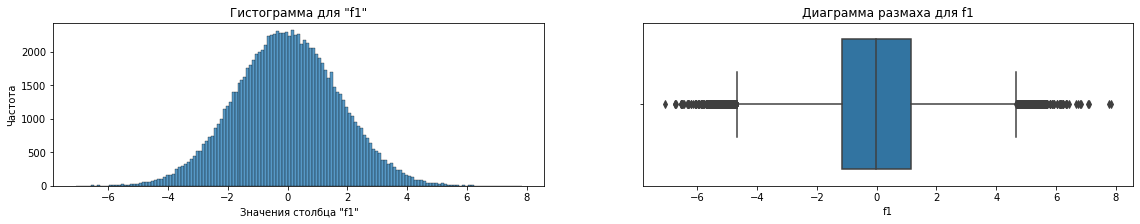

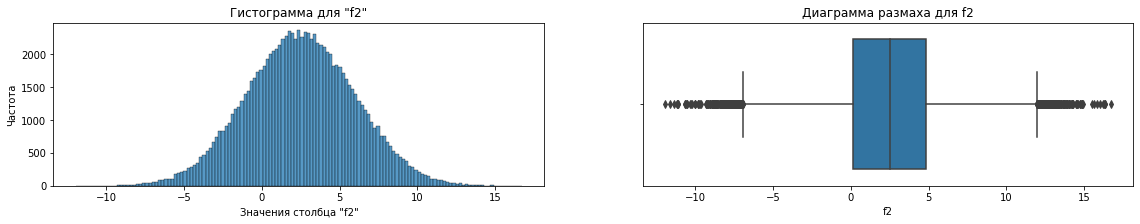

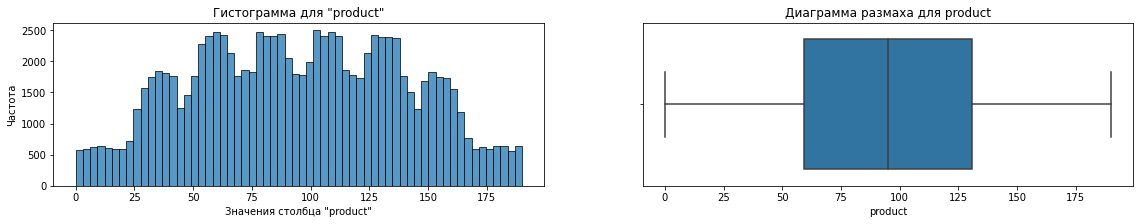

In [41]:
# вызовим функцию для построения гистрорамм и диаграмм размаха для количественных признаков
for name in geo_data_2.select_dtypes(include = 'number').columns:
    hist_box(geo_data_2, name)
    plt.show()

Признаки `f0`, `f1`, `f2` походят на нормальное распределеление, но попадаются выбросы. Здесь также непонято стоит ли их удалять, так как мало информации о их значении. Если при оценке качества модели будут получаться плохие результаты, можно попробывать удалить выбросы.

Целевой признак не имеет чекткого распределения, выбросов не наблюдается.

Признаки во всех регионах распределены по разному, хотя попдаются схожие распределения. Возможно для каких-то регионов было сделано недостачно исследований, поэтому распределения отличаются, или на это повлияло различная физика нефти, геология, также не исключено, что распределение впринципе имеет сложный характер который не описать с помощью обычных распределений. Одна модель с определенным набором параметров может хорошо уловить связь для одного региона, а для другого справиться хуже, поэтому нужно искать различный подход для получения лучшего качества модели.

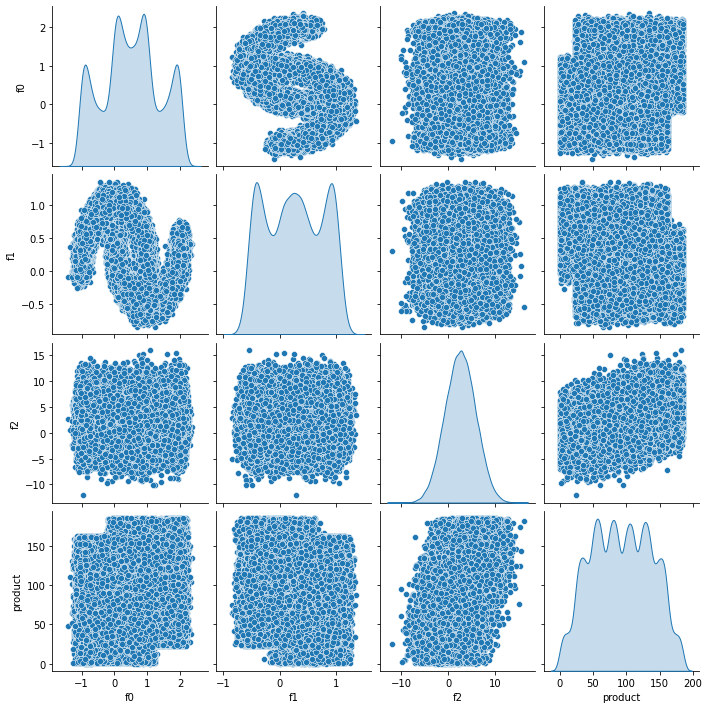

In [42]:
# построим матрицу диаграмм рассиения и оценим связь между признаками
sns.pairplot(geo_data_0.select_dtypes(include = 'number'),diag_kind = 'kde')
plt.show()

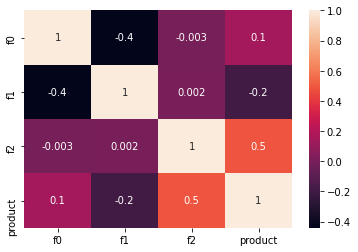

In [43]:
#
sns.heatmap(geo_data_0.select_dtypes(include = 'number').corr(), annot = True, fmt='.1g')
plt.show()

Мультиколлинеарность не наблюдается. 

Заметная прямая связь целевого признака с `f2`. С остальными признаками слабая связь, возмжно стоит добавить новые признаки при обучении модели.

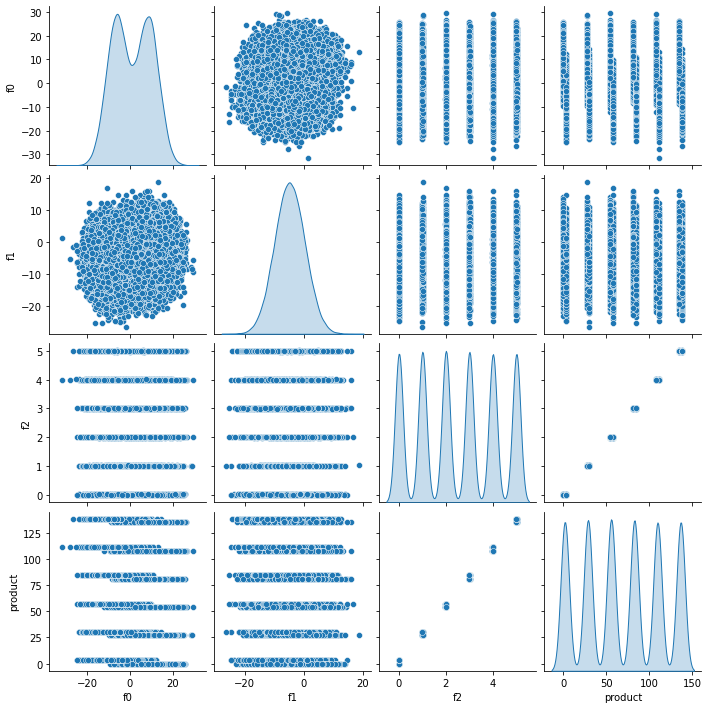

In [44]:
# построим матрицу диаграмм рассиения и оценим связь между признаками
sns.pairplot(geo_data_1.select_dtypes(include = 'number'),diag_kind = 'kde')
plt.show()

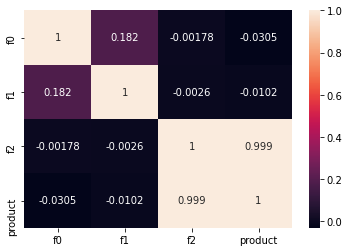

In [45]:
sns.heatmap(geo_data_1.select_dtypes(include = 'number').corr(), annot = True, fmt='.3g')
plt.show()

Мультиколлинеарность не наблюадается.

Весьма высокая прямая связь(0.999) целевого признака с `f2` что похоже на утечку, но если не учитывать данный признак, то модель вообще не надёт связи между другими значениями, так как корреляция с другими признаками очень слабая.

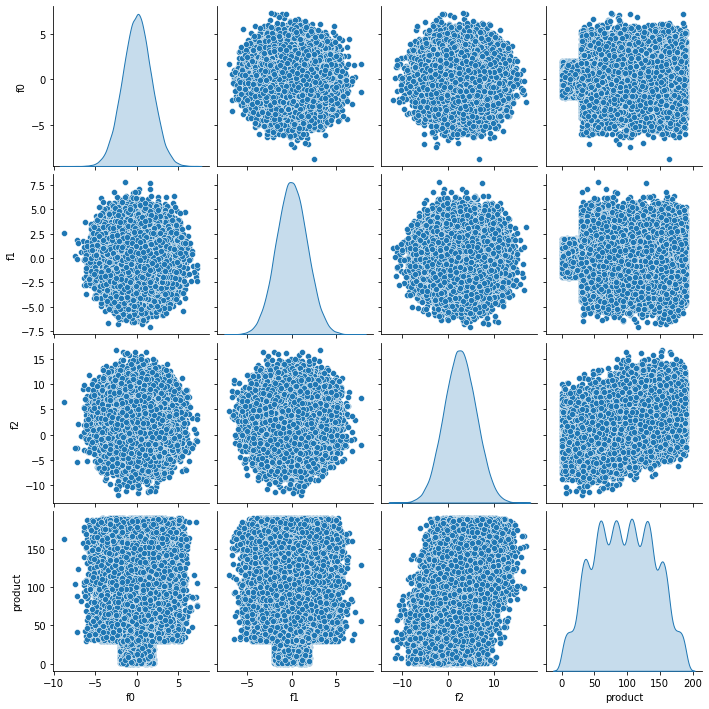

In [46]:
# построим матрицу диаграмм рассиения и оценим связь между признаками
sns.pairplot(geo_data_2.select_dtypes(include = 'number'),diag_kind = 'kde')
plt.show()

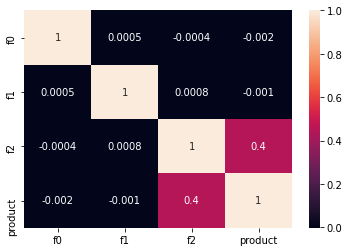

In [47]:
sns.heatmap(geo_data_2.select_dtypes(include = 'number').corr(), annot = True, fmt='.1g')
plt.show()

Мультиколлинеарность не наблюдается.

Умеренная прямая связь целевого признака с `f2`, а с остальными она практически отсутствует, возможно также нужно добавить новые признаки для лучшего обучения модели.

Вывод:
1) Попадаются выбросы, но их смысл непонянет, решили оставить, в случае плохого качества модели попробывать удалить.
2) Корреляция целевого признака с остальными очень слабая кроме `f2`.
3) Наблюдается учечка целевого признака с `f2` в данных `geo_data_2`, решили оставить, так как с отальными признаками связь очень слабая.
4) Возможно придется добавить новые признаки для лучшего обучения модели.

## Обучение и проверка модели

Обучим модель и проверим её для каждого региона.

Данные поделим на тренировочную и валидационную выборку в соотношении 75:25.

Сохраним предсказания и правильные ответы на валидационной выборке.

Определим средний запас предсказанного сырья и RMSE модели.

### Регион 0

In [48]:
# создадим функцию для создания модели линейной регрессии
def model_linearreg(datset):

    # разделим данные на входные и целевые признаки
    X = datset.set_index('id').drop(columns = 'product')
    y = datset.set_index('id')[['product']]

    
    #сформируем обучающие и валидационные выборки
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, 
        y,
        test_size = TEST_SIZE,
        random_state=RANDOM_STATE
    )

    # пайплайн 
    final_p = Pipeline(
        [
            ('poly', PolynomialFeatures(degree=2)),
            ('preprocessor', StandardScaler()),
            ('feature_selection', SelectKBest(f_regression)),
            ('models', LinearRegression())
        ]
    )
    
    # создаём словарь с гиперпараметрами
    param_grid = {
        'preprocessor': [
            StandardScaler(),
            MinMaxScaler(),
            RobustScaler(), 
            'passthrough'
        ],
        'feature_selection__k': range(3, 10)
    }
    
    # используем GridSearchCV для поиска лучших параметров
    grid = GridSearchCV(
        final_p, 
        param_grid=param_grid,
        cv=5, 
        scoring ='neg_mean_squared_error', 
        n_jobs = -1
    )
    
    # обучаем на тренировочных данных
    grid.fit(X_train, y_train)

    # сохраним модель с лучшими параметрами
    best_model = grid.best_estimator_

    # рассчитываем метрику при кросс-валидаци
    rmse_grid = np.sqrt(grid.best_score_*-1)

    #предсказываем целевой признак
    y_pred = grid.predict(X_valid)

    # рассчитываем метрику rmse на валидационной выборке
    mse = mean_squared_error(y_valid, y_pred)
    rmse = np.sqrt(mse)
    
    return X_train, X_valid, y_train, y_valid, y_pred, rmse, rmse_grid, best_model

In [49]:
%%time

# сохраним в переменные результаты функции model_linearreg()
X_train, X_valid, y_train, y_valid, y_pred, rmse, rmse_grid, best_model = model_linearreg(geo_data_0)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

CPU times: user 30.3 s, sys: 24.9 s, total: 55.2 s
Wall time: 55.6 s


In [50]:
# сохраним значения признаков после применения полиномизации
X_train_poly = pd.DataFrame(best_model[0].fit_transform(X_train), columns = best_model[0].get_feature_names_out())

In [51]:
X_train_poly.head()

,1,f0,f1,f2,f0^2,f0 f1,f0 f2,f1^2,f1 f2,f2^2
0,1.0,1.611925,-0.151874,1.221668,2.598302,-0.244810,1.969237,0.023066,-0.185540,1.492473
1,1.0,-0.896203,0.369086,-4.537914,0.803180,-0.330776,4.066893,0.136225,-1.674881,20.592665
2,1.0,0.217569,0.974254,7.369521,0.047336,0.211967,1.603376,0.949171,7.179787,54.309837
3,1.0,0.882945,0.669249,3.114527,0.779592,0.590910,2.749958,0.447894,2.084393,9.700281
4,1.0,-0.941661,0.634162,2.873607,0.886726,-0.597166,-2.705964,0.402162,1.822333,8.257617


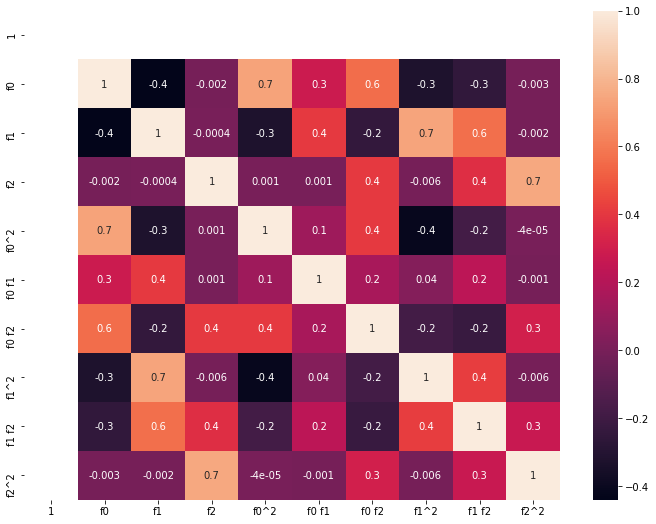

In [52]:
# посмотрим нет ли сильной корреляции между признакми после полиномизации
plt.figure(figsize=(12, 9))
sns.heatmap(X_train_poly.select_dtypes(include = 'number').corr(), annot = True, fmt='.1g')
plt.show()

Мультиколлинеарности не наблюдается.

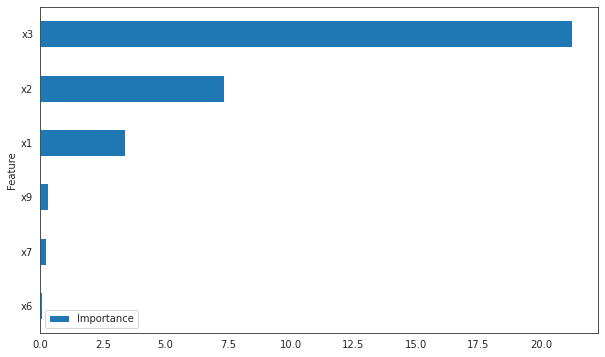

In [53]:
# посмторим какой вклад внес каждый признак
coefficients = best_model[3].coef_[0]
sns.set_style('white')
feature_importance = pd.DataFrame({'Feature': best_model[2].get_feature_names_out(), 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.show()

Наибольший вклад внесли начальные признаки `f0`, `f1`, `f2`. Добавленные признаки с помощью полиномизации особо не помогли.

In [54]:
print('Фактический Средний запас сырья(тыс.баррелй) на валидационной выборке = ', round(y_valid['product'].mean(), 3))
print(f'Средний запас предсказанного сырья(тыс.баррелй) = {round(pd.DataFrame(y_pred)[0].mean(), 3)}')
print(f'RMSE при кросс-валидации = {round(rmse_grid, 3)} (тыс.баррлей)')
print(f'RMSE на валидационной выборке = {round(rmse, 3)} (тыс.баррлей)')

Фактический Средний запас сырья(тыс.баррелй) на валидационной выборке =  92.326
Средний запас предсказанного сырья(тыс.баррелй) = 92.401
RMSE при кросс-валидации = 37.674 (тыс.баррлей)
RMSE на валидационной выборке = 37.756 (тыс.баррлей)


Модель получилась получилась оптимистичной, в среднем запас сырья на предсказаных значениях получился больше на 75 баррелей.

По метрике RMSE модель не очень хорошего качества, но предсказанный средний объём запасов достаточно близок к фактическому среднему объму запасов.

### Регион 1 

In [55]:
%%time

# сохраним в переменные результаты функции model_linearreg()
X_train_1, X_valid_1, y_train_1, y_valid_1, y_pred_1, rmse_1, rmse_grid_1, best_model_1 = model_linearreg(geo_data_1)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

CPU times: user 30.2 s, sys: 24.2 s, total: 54.4 s
Wall time: 54.8 s


In [56]:
# сохраним значения признаков после применения полиномизации
X_train_1poly = pd.DataFrame(best_model_1[0].fit_transform(X_train), columns = best_model_1[0].get_feature_names_out())

In [57]:
X_train_1poly.head()

,1,f0,f1,f2,f0^2,f0 f1,f0 f2,f1^2,f1 f2,f2^2
0,1.0,1.611925,-0.151874,1.221668,2.598302,-0.244810,1.969237,0.023066,-0.185540,1.492473
1,1.0,-0.896203,0.369086,-4.537914,0.803180,-0.330776,4.066893,0.136225,-1.674881,20.592665
2,1.0,0.217569,0.974254,7.369521,0.047336,0.211967,1.603376,0.949171,7.179787,54.309837
3,1.0,0.882945,0.669249,3.114527,0.779592,0.590910,2.749958,0.447894,2.084393,9.700281
4,1.0,-0.941661,0.634162,2.873607,0.886726,-0.597166,-2.705964,0.402162,1.822333,8.257617


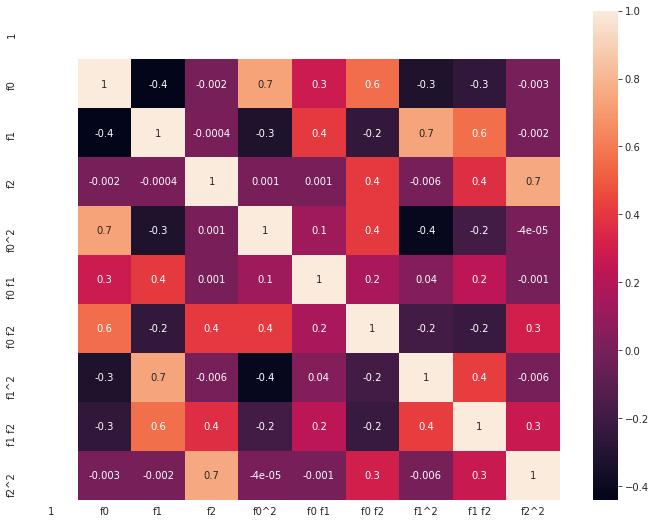

In [58]:
# посмотрим нет ли сильной корреляции между признакми после полиномизации
plt.figure(figsize=(12, 9))
sns.heatmap(X_train_1poly.select_dtypes(include = 'number').corr(), annot = True, fmt='.1g')
plt.show()

Мультиколлинеарности не наблюдается.

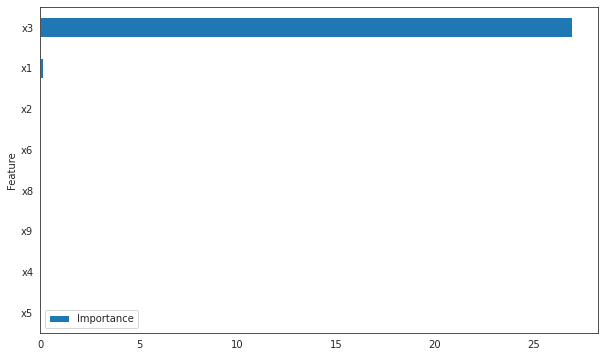

In [59]:
# посмторим какой вклад внес каждый признак
coefficients = best_model_1[3].coef_[0]
sns.set_style('white')
feature_importance = pd.DataFrame({'Feature': best_model_1[2].get_feature_names_out(), 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.show()

Наибольший вклад внес признак `f2`, что впринице было предсказуемо, так как у него весьма высокая прямая связь с целевым признаком(0.99), у остальных она совсем маленькая.

Добавленные признаки с помощью полиномизации не помогли.

In [60]:
print('Фактический Средний запас сырья(тыс.баррелй) на валидационной выборке = ', round(y_valid_1['product'].mean(), 3))
print(f'Средний запас предсказанного сырья(тыс.баррелй) = {round(pd.DataFrame(y_pred_1)[0].mean(), 3)}')
print(f'RMSE при кросс-валидации = {round(rmse_grid_1, 3)} (тыс.баррлей)')
print(f'RMSE на валидационной выборке = {round(rmse_1, 3)} (тыс.баррлей)')

Фактический Средний запас сырья(тыс.баррелй) на валидационной выборке =  68.725
Средний запас предсказанного сырья(тыс.баррелй) = 68.713
RMSE при кросс-валидации = 0.89 (тыс.баррлей)
RMSE на валидационной выборке = 0.89 (тыс.баррлей)


По метрике RMSE модель ошибается всего на 890 баррелей и по среденим запасам отличается от фактических всего на 15 баррелей. Сильная прямая связь целевого признака с `f2` сыграла свою роль.

Возможно это учечка целевого признака, но опять же мало информации о входных признаков, чтобы это обосновать.

### Регион 2

In [61]:
%%time

# сохраним в переменные результаты функции model_linearreg()
X_train_2, X_valid_2, y_train_2, y_valid_2, y_pred_2, rmse_2, rmse_grid_2, best_model_2 = model_linearreg(geo_data_2)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

CPU times: user 30.2 s, sys: 24 s, total: 54.2 s
Wall time: 54.8 s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [62]:
# сохраним значения признаков после применения полиномизации
X_train_2poly = pd.DataFrame(best_model_2[0].fit_transform(X_train), columns = best_model_2[0].get_feature_names_out())

In [63]:
X_train_2poly.head()

,1,f0,f1,f2,f0^2,f0 f1,f0 f2,f1^2,f1 f2,f2^2
0,1.0,1.611925,-0.151874,1.221668,2.598302,-0.244810,1.969237,0.023066,-0.185540,1.492473
1,1.0,-0.896203,0.369086,-4.537914,0.803180,-0.330776,4.066893,0.136225,-1.674881,20.592665
2,1.0,0.217569,0.974254,7.369521,0.047336,0.211967,1.603376,0.949171,7.179787,54.309837
3,1.0,0.882945,0.669249,3.114527,0.779592,0.590910,2.749958,0.447894,2.084393,9.700281
4,1.0,-0.941661,0.634162,2.873607,0.886726,-0.597166,-2.705964,0.402162,1.822333,8.257617


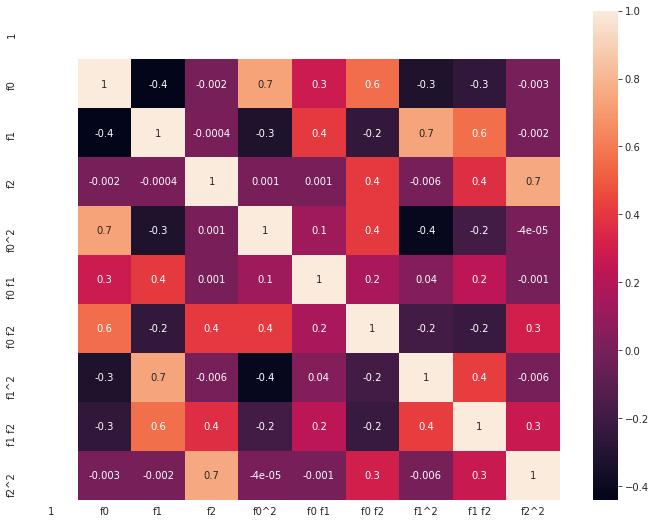

In [64]:
# посмотрим нет ли сильной корреляции между признакми после полиномизации
plt.figure(figsize=(12, 9))
sns.heatmap(X_train_2poly.select_dtypes(include = 'number').corr(), annot = True, fmt='.1g')
plt.show()

Мультиколлинеарности не наблюдается.

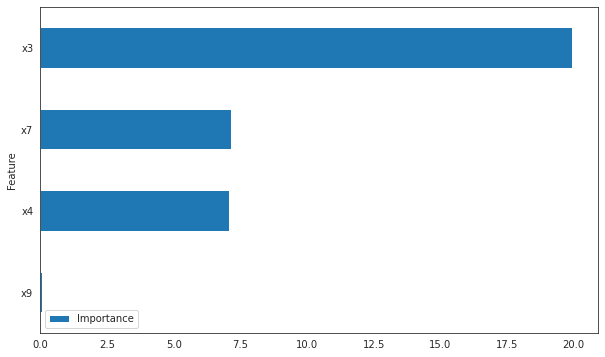

In [65]:
# посмторим какой вклад внес каждый признак
coefficients = best_model_2[3].coef_[0]
sns.set_style('white')
feature_importance = pd.DataFrame({'Feature': best_model_2[2].get_feature_names_out(), 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.show()

Признак `f2` имел умеренную прямую связь с целевым признаком, он внес наибольший вклад. Добавление новых признаков `f0^2` и `f1^2` помогло лучше обучиться модели.

In [66]:
print('Фактический Средний запас сырья(тыс.баррелй) на валидационной выборке = ', round(y_valid_2['product'].mean(), 3))
print(f'Средний запас предсказанного сырья(тыс.баррелй) = {round(pd.DataFrame(y_pred_2)[0].mean(), 3)}')
print(f'RMSE при кросс-валидации = {round(rmse_grid_2, 3)} (тыс.баррлей)')
print(f'RMSE на валидационной выборке = {round(rmse_2, 3)} (тыс.баррлей)')

Фактический Средний запас сырья(тыс.баррелй) на валидационной выборке =  95.151
Средний запас предсказанного сырья(тыс.баррелй) = 94.761
RMSE при кросс-валидации = 38.744 (тыс.баррлей)
RMSE на валидационной выборке = 38.878 (тыс.баррлей)


Разница в среднем запасе сырья фактического и предсказанного 390 баррелей, что в принципе не так много. По метрике rsme модель на валидационной выборке в среднем ошибается на 38.878 тыс.баррелей.

## Подготовка к расчётам прибыли

Сохраним все ключевые услвовия в переменных.

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.

Сравним полученный объём сырья со средним запасом в каждом регионе.

In [67]:
# кол-во скважин в регионе для исследования
well = 500
# среди 500 скважин выбирают 200 лучших из них для разработки
well_best = 200
# цена в рублях за один баррель
price_barrel = 450
# бюджет на разработку скважин в регионе в рублях
budget = 10000000000
# бюджет на разработку одной скважины в регионе в рублях
budget_onewell = budget/well_best

In [68]:
for i in range(1000000):
    if (i*price_barrel - budget/1000) >= 0:
        print('Объём сырья в тыс.барр. для безубыточной разработки 200 скважин =', i)
        print('Объём сырья в тыс.барр. для безубыточной разработки одной скважины =', i/200)
        break
print('Средний запас сырья тыс.барр в первом регионе =', geo_data_0['product'].mean().round(3))
print('Средний запас сырья тыс.барр в втором регионе =', geo_data_1['product'].mean().round(3))
print('Средний запас сырья тыс.барр в третьем регионе =', geo_data_2['product'].mean().round(3))

Объём сырья в тыс.барр. для безубыточной разработки 200 скважин = 22223
Объём сырья в тыс.барр. для безубыточной разработки одной скважины = 111.115
Средний запас сырья тыс.барр в первом регионе = 92.5
Средний запас сырья тыс.барр в втором регионе = 68.825
Средний запас сырья тыс.барр в третьем регионе = 95.0


При бюджете в 10 млрд.рублей на 200 скважин, для безубычточной разработки 1 скважины, она должна потенциальное иметь объём запасов = 111.115 тыс.баррелей.

В среднем запасы сырья в тыс.барр в каждом регионе не удовлетворяют условию выполнения безубыточной разработки 1 скважины, поэтому нужно подбирать такие скважины, у которых запасы больше или равны 111.115 тыс.барр и при этом вероятноть предсказания обёмов запасов скважины должна быть довольно высокой.

## Расчёт прибыли и рисков 

Создадим функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели: 

1) Выберем скважины с максимальными значениями предсказаний.
2) Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.
3) Рассчитаем прибыль для полученного объёма сырья.

Посчитайем риски и прибыль для каждого региона:
1) Применим технику Bootstrap с 1000 выборок.
2) Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков.
3) Предложим регион для разработки скважин.

In [74]:
# создадим функицю для расчёта прибыли
def calculate_profit(target, prediction):
    
    #выбераем 200 лучших скважин
    best_predicted = pd.Series(prediction).sort_values(ascending=False).head(200)
    
    #сохраняем 200 лучших скважин с фактическими запасами в тыс.барр
    best_predicted_real = target[best_predicted.index]

    # считаем сумму запасов 200 скважин в тыс.барр
    total_product = best_predicted_real.sum()

    #считаем выручку в рублях
    total_income = total_product * price_barrel*1000

    #определям прибыль в рублях
    total_profit = total_income - budget
    
    return total_profit

In [75]:
# создадим функцию Bootstrap() для подсчётов рисков и прибыли для каждого региона 
def bootstrap(y_true, y_predict, region):

    #используем функцию RandomState() для создания разных подвыброк
    state = np.random.RandomState(10000)

    # для сохрания прибыли 200 лучших скважин
    bootstrap_profit = []
    
    # сохраняем предсказанные запасы
    pred = pd.DataFrame(y_predict)[0]

    # фактические запасы
    valid = y_true.reset_index(drop = True)['product']

    for _ in range(1000):
        
        # сохраняем случайных 500 скважин
        samples = valid.sample(500, random_state=state)
        
        # выбераем 500 скважин с запасами предесказанных моделью
        samples_pred = pred[samples.index]

        # вызвываем функцию calculate_profit() для подсчёта прибыли и переводим в млрд.рублей
        samples_profit = calculate_profit(samples, samples_pred) / 1000000000
        
        # добавляем значения прибыли в список bootstrap_profit
        bootstrap_profit.append(samples_profit)

    # переводим списко в series
    bootstrap_profit = pd.Series(bootstrap_profit)

    print('Cредняя прибыль в млрд.рублей', bootstrap_profit.mean().round(3))
    print(f'95% Доверительный интервал {bootstrap_profit.quantile(0.025).round(3)} - {bootstrap_profit.quantile(0.975).round(3)}')
    print(f'Вероятнотсь понести убытки {round(bootstrap_profit[bootstrap_profit < 0].size*100/bootstrap_profit.size, 3)}')

    f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.85, .15)})

    # отобазим распределение прибыли 
    sns.histplot(bootstrap_profit, kde=True, ax=ax_hist).set(title='Распределение прибыли, регион ' + str(region), ylabel='Количество')

    # оценим диаграмму размаха
    sns.boxplot(bootstrap_profit.values, orient = 'h', ax=ax_box).set(xlabel='Прибыль (млрд. руб.)')
    
    plt.show()

    return 

Cредняя прибыль в млрд.рублей 0.407
95% Доверительный интервал -0.08 - 0.935
Вероятнотсь понести убытки 5.2


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


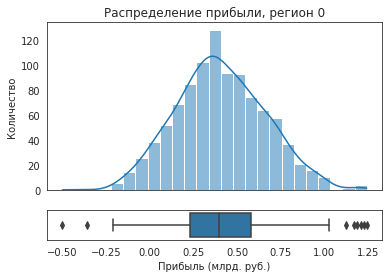

In [76]:
bootstrap(y_valid, y_pred, 0)

Cредняя прибыль в млрд.рублей 0.448
95% Доверительный интервал 0.037 - 0.836
Вероятнотсь понести убытки 1.7


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


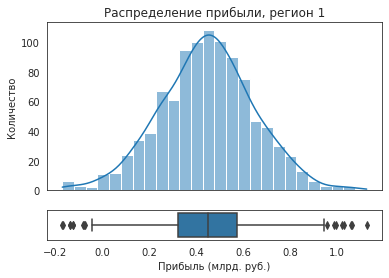

In [77]:
bootstrap(y_valid_1, y_pred_1, 1)

Cредняя прибыль в млрд.рублей 0.578
95% Доверительный интервал 0.042 - 1.068
Вероятнотсь понести убытки 1.6


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


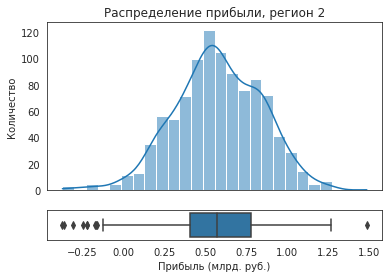

In [78]:
bootstrap(y_valid_2, y_pred_2, 2)

Первый регион нам не подходит так как вероятность убытков больше 2.5%. Остальные регионы выполняют условие по убыткам, но регион 2 в среднем иммет больше прибыли на 0.13 млрд.рублей или на 130 млн.рублей, поэтому для разработки лучше рассмотреть его.

## Общий вывод

По предобработке данных не было каких-то серьёзных проблем. 

По исследовательскому анализу были замечаны выбросы, нестандартные распределения данных, было решено оставить изначальный набор значений, так как мало информации о природе признаков. Мультиколлинеарность между признаками не обнаружено, но между целевым признаком и `f2` высокая прямая связь, что похоже на утечку данных. Так как опять же природа признаков не известна, нет оснований удалять `f2` для устранения утечки целевого признака. 

Обучили модели линейной регрессии для 3 регионов.

Для региона `0` получили следущие параметры:

- Средний запас предсказанного сырья(тыс.баррелй) = 92.401.
- RMSE при кросс-валидации = 37.674 (тыс.баррлей.
- RMSE на валидационной выборке = 37.756 (тыс.баррле.

Для региона `1` получили следущие параметры:

- Средний запас предсказанного сырья(тыс.баррелй) = 68.713.
- RMSE при кросс-валидации = 0.89 (тыс.баррлей).
- 
RMSE на валидационной выборке = 0.89 (тыс.баррлей.)

Для региона `2` получили следущие параметр

- Средний запас предсказанного сырья(тыс.баррелй) = 94.761
-
RMSE при кросс-валидации = 38.744 (тыс.баррле).й
-
RMSE на валидационной выборке = 38.878 (тыс.баррле.

Лучше прогнозы получились для региона `1` из-за высокой прямой связи(0.99) целевого признака с `f2`, но достверность под сомнениям, так как возможно это утечка целевого признака. 


Для безубыточной разработки новой скважины нужнен объём сырья 111.115 тыс.баррелей. Средний объём сырья по регионам меньше чем 111.115 тыс.баррелей на 1 скважину, поэтому нужно выбирать скважины с максмиальными запасами.

Техникой Bootstrap опеределили распределени прибыли для регионов. Получилось, чот для лучший регион для разботки скважи -н `2`, так как вероятность понести убытки 1.6% и средняя прибыль среди всех остальных регионов больше и равна 0.578 млрд.рублей.)